In [1]:
from dataset import *
from evaluator import *
from torch.utils.data import DataLoader

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt

import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [2]:
image_size = 64

trans = transforms.Compose([transforms.ToPILImage(),
                            transforms.Resize([image_size, image_size]),
                            transforms.CenterCrop([image_size, image_size]),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5)), # normalize to [-1, 1] for the last layer of generator is tanh()
                            ])

# preprocessing size -> 64x64
train = ICLEVRLoader("./", trans=trans, mode="train", preprocessing=None)
test = ICLEVRLoader("./", mode="test")

batch_size = 128
train_loader = DataLoader(
    dataset=train, 
    batch_size=batch_size,
    num_workers = 4
)

# [C, H, W] == [3, 512, 512]
test_loader = DataLoader(
    dataset=test,
    batch_size=batch_size,
    num_workers = 4
)

> Found 18009 images...
> Found 32 label...


In [3]:
class Generator(nn.Module):
    def __init__(self, n_classes, latent_dim, img_shape, n_channels):
        super(Generator, self).__init__()
        
        self.n_classes = n_classes
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.input_cnn = nn.Linear(latent_dim, 256)
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
#             nn.ConvTranspose2d( img_shape, img_shape*8 , 4, 1, 0, bias=False), #input shape [batch_size, 64, 1, 1]
            nn.ConvTranspose2d( img_shape, img_shape*8 , 4, 2, 1, bias=False), # input shape [batch_size, 64, 2, 2]
            nn.BatchNorm2d(img_shape*8),
            nn.ReLU(True),
            # state size. (img_shape*8) x 4 x 4
            nn.ConvTranspose2d(img_shape * 8, img_shape * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 4),
            nn.ReLU(True),
            # state size. (img_shape*4) x 8 x 8
            nn.ConvTranspose2d( img_shape * 4, img_shape * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 2),
            nn.ReLU(True),
            # state size. (img_shape*2) x 16 x 16
            nn.ConvTranspose2d( img_shape * 2, img_shape, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape),
            nn.ReLU(True),
            # state size. (img_shape) x 32 x 32
            nn.ConvTranspose2d( img_shape, n_channels, 4, 2, 1, bias=False),
            nn.Tanh() # based on DCGAN paper
            # state size. (n_channels) x 64 x 64
        )

    def forward(self, noise):
#         gen_input = torch.cat((labels, noise), -1).float()
        gen_input = self.input_cnn(noise).view(batch_size, 64, 2, 2)
        img = self.main(gen_input)
        return img


class Discriminator(nn.Module):
    def __init__(self, n_classes, img_shape):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.img_shape= img_shape
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        
        self.label_linear = nn.Linear(n_classes, img_shape*img_shape)        
        
        self.main = nn.Sequential(
            # input is (n_classes) x 64 x 64
            nn.Conv2d(3, img_shape, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape) x 32 x 32
            nn.Conv2d(img_shape, img_shape * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*2) x 16 x 16
            nn.Conv2d(img_shape * 2, img_shape * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*4) x 8 x 8
            nn.Conv2d(img_shape * 4, img_shape * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*8) x 4 x 4
            nn.Conv2d(img_shape * 8, 1, 4, 1, 0, bias=False),
            
            nn.Sigmoid()
        )

    def forward(self, img):
        # Concatenate label embedding and image to produce input
#         labels = self.label_linear(labels.float()).view(-1, 1, self.img_shape, self.img_shape)
#         d_in = torch.cat((img, labels), 1)
        validity = self.main(img).view(-1, 1)

        return validity

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# loss function
adversarial_loss = torch.nn.BCELoss()

# model 
n_classes = 24
latent_dim = 100
img_shape = 64
n_channels = 3
generator = Generator(n_classes, latent_dim, img_shape, n_channels).to(device)
discriminator = Discriminator(n_classes, img_shape).to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

# optimizer 
lr = 0.0002
b1 = 0.5
b2 = 0.999
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [5]:
def save_acc(g_loss, d_loss):
    try:
        acc = np.load("loss.npz")
        np_g_loss = acc['g_loss']
        np_d_loss = acc['d_loss']
        np_g_loss = np.append(np_g_loss, g_loss)
        np_d_loss = np.append(np_d_loss, d_loss)
        np.savez('loss.npz', g_loss=np_g_loss, d_loss=np_d_loss)
    except:
        g_loss = np.array(g_loss)
        d_loss = np.array(d_loss)
        np.savez('loss.npz', g_loss=g_loss, d_loss=d_loss)

In [6]:
# training 
epochs = 10
n_critic = 5 # number of training steps for discriminator per iter
save = True
FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor
g_loss_list = []
d_loss_list = []

for epoch in tqdm.notebook.tqdm(range(epochs)):
    total_d_loss = 0
    total_g_loss = 0
    
    for i, (real_imgs, labels) in enumerate(train_loader):
        batch_size = real_imgs.shape[0]

        real_imgs = real_imgs[:, :3].to(device)
        real_labels = labels.to(device)
        
        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device) # shape [batch_size, 1]
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device) # shape [batch_size, 1]

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device) # shape [batch_size, latent_dim] with normal distribution
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, (batch_size, 1)))) # shape [batch_size, 1] with 0~24
        
        # Generate a batch of images
        gen_imgs = generator(z) # shape [batch_size, 3, 64, 64]

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        
    # loss save
    if save:
        save_acc(total_g_loss, total_d_loss)
    else:
        g_loss_list.append(total_g_loss)
        d_loss_list.append(total_d_loss)

    total_d_loss /= len(train_loader)
    total_g_loss /= len(train_loader)
    g_loss_list.append(total_g_loss)
    d_loss_list.append(total_d_loss)
    
    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, epochs, total_d_loss, total_g_loss)
    )

if save:
    print("Saving model weight...")
    torch.save(discriminator, "./discriminator.pt")
    torch.save(generator, "./generator.pt")
    print("Save Done!")

[Epoch 1/10] [D loss: 0.379719] [G loss: 8.575253]
[Epoch 2/10] [D loss: 0.162627] [G loss: 4.190827]
[Epoch 3/10] [D loss: 0.161509] [G loss: 3.323377]
[Epoch 4/10] [D loss: 0.153876] [G loss: 3.550147]
[Epoch 5/10] [D loss: 0.152409] [G loss: 3.611441]
[Epoch 6/10] [D loss: 0.132591] [G loss: 3.839722]
[Epoch 7/10] [D loss: 0.172780] [G loss: 3.852814]
[Epoch 8/10] [D loss: 0.084558] [G loss: 3.763631]
[Epoch 9/10] [D loss: 0.208740] [G loss: 4.247568]
[Epoch 10/10] [D loss: 0.087273] [G loss: 3.867185]

Saving model weight...
Save Done!


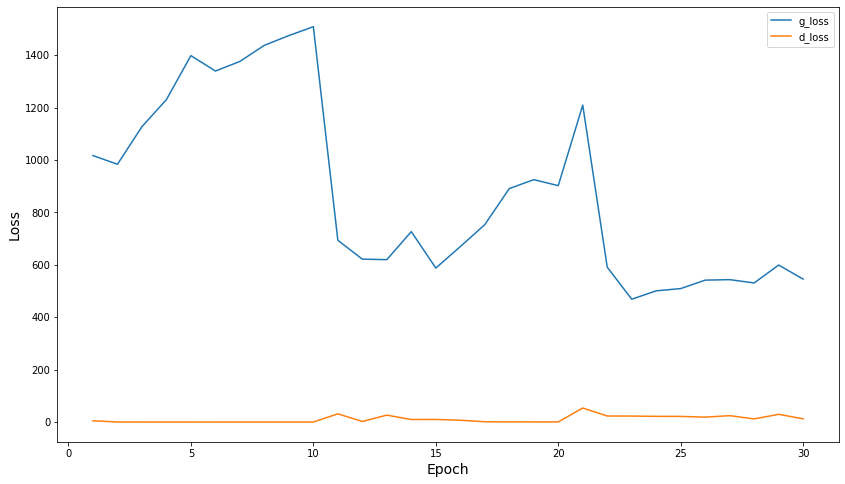

In [7]:
plt.figure(figsize=(14, 8))

load = True
if load:
    acc = np.load('loss.npz')
    g_loss = acc['g_loss']
    d_loss = acc['d_loss']

# plt.title("Activation Function comparision(EEGNet)", fontsize=18)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
x = np.arange(1, len(g_loss)+1)
plt.plot(x, g_loss, label="g_loss")
plt.plot(x, d_loss, label="d_loss")
plt.legend()
plt.show()

In [25]:
## evaluate
batch_size = 8
z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device) # shape [batch_size, latent_dim] with normal distribution
gen_imgs = generator(z) # shape [batch_size, 3, 64, 64]

0.06666666666666667


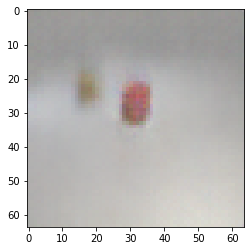

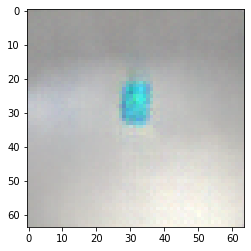

In [26]:
eval_model = evaluation_model()


 # step 1: convert it to [0 ,2]
gen_imgs = gen_imgs +1

 # step 2: convert it to [0 ,1]
gen_imgs = gen_imgs - gen_imgs.min()
gen_imgs = gen_imgs / (gen_imgs.max() - gen_imgs.min())

print(eval_model.eval(gen_imgs[:], labels))

plt.imshow(np.transpose(gen_imgs[0].detach().cpu().numpy(), (1, 2, 0)))
plt.show()
plt.imshow(np.transpose(gen_imgs[1].detach().cpu().numpy(), (1, 2, 0)))
plt.show()


In [10]:
eval_model = evaluation_model()
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    out = F.interpolate(images, size=64)  #The resize operation on tensor.
    print(out.shape)
    print(eval_model.eval(images[:, :3], labels))
#     grid = make_grid(out)
    break

torch.Size([128, 4, 64, 64])
0.9647058823529412


torch.Size([4, 64, 64])


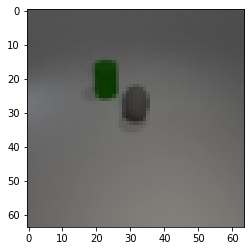

In [11]:
img, label = train.__getitem__(4)

 # step 1: convert it to [0 ,2]
img = img +1

 # step 2: convert it to [0 ,1]
img = img - img.min()
img = img / (img.max() - img.min())

print(img.shape)
plt.imshow(np.transpose(img,(1,2,0)))

In [12]:
for x, y in train_loader:
    print(x)
    break

tensor([[[[-0.1765, -0.1765, -0.1765,  ..., -0.1922, -0.1922, -0.1922],
          [-0.1686, -0.1765, -0.1686,  ..., -0.1922, -0.1922, -0.1922],
          [-0.1686, -0.1765, -0.1765,  ..., -0.1922, -0.1922, -0.1922],
          ...,
          [-0.0745, -0.0745, -0.0667,  ...,  0.1373,  0.1373,  0.1294],
          [-0.0745, -0.0745, -0.0667,  ...,  0.1451,  0.1373,  0.1373],
          [-0.0824, -0.0745, -0.0667,  ...,  0.1451,  0.1373,  0.1373]],

         [[-0.1765, -0.1765, -0.1765,  ..., -0.1922, -0.1922, -0.1922],
          [-0.1765, -0.1765, -0.1765,  ..., -0.1922, -0.1922, -0.1922],
          [-0.1686, -0.1765, -0.1765,  ..., -0.2000, -0.1922, -0.1922],
          ...,
          [-0.0824, -0.0824, -0.0745,  ...,  0.1216,  0.1137,  0.1137],
          [-0.0824, -0.0824, -0.0745,  ...,  0.1216,  0.1137,  0.1137],
          [-0.0824, -0.0745, -0.0745,  ...,  0.1294,  0.1216,  0.1137]],

         [[-0.1765, -0.1765, -0.1765,  ..., -0.1922, -0.1922, -0.1922],
          [-0.1765, -0.1765, -